In [13]:
import os
import pandas as pd
from datetime import datetime
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

from sklearn.decomposition import PCA

## Datenimport
Quelle der Daten: https://data.milwaukee.gov/dataset/property-sales-data

In [2]:
FILEPATH = os.path.join('..', 'input', 'armslengthsales_2022_valid.csv')

In [3]:
df = pd.read_csv(FILEPATH)

# Hilfsfunktionen

In [4]:
def print_evaluation(name, cv, pipe, train_data, test_data, y, X):
    print(f'{name} - Cross validation {cv}')
    print(f'{name} -     In-sample -  mae: {mean_absolute_error(y_true=train_data[y], y_pred=pipe.predict(train_data[X])):.2f}')
    print(f'{name} -     In-sample - mape: {mean_absolute_percentage_error(y_true=train_data[y], y_pred=pipe.predict(train_data[X]))*100:.2f}%')
    print(f'{name} - Out-of-sample -  mae: {mean_absolute_error(y_true=test_data[y], y_pred=pipe.predict(test_data[X])):.2f}')
    print(f'{name} - Out-of-sample - mape: {mean_absolute_percentage_error(y_true=test_data[y], y_pred=pipe.predict(test_data[X]))*100:.2f}%')
    print(f'{name} - Out-of-sample - rsme: {np.sqrt(mean_squared_error(y_true=test_data[y], y_pred=pipe.predict(test_data[X]))):.2f}')
    print(f'{name} - Out-of-sample -   r2: {pipe.score(X=test_data[X], y=test_data[y]):.2f}')

def plot_train_vs_test_predictions(pipe, train_data, test_data, X, y):
    train_predictions = pipe.predict(train_data[X])
    test_predictions = pipe.predict(test_data[X])

    plt.figure(figsize=(10, 5))
    plt.scatter(train_predictions, train_data[y], color='blue', label='Trainingsdaten')
    plt.scatter(test_predictions, test_data[y], color='red', label='Testdaten')
    plt.xlabel('Vorhergesagter Verkaufspreis')
    plt.ylabel('Tatsächlicher Verkaufspreis')
    plt.title('Vorhersagen vs. Tatsächliche Werte')
    plt.ticklabel_format(style='plain', axis='x') # Wird benötigt, damit die Werte nicht als 0,2 x 10^X dargestellt werden sondern als Ganzzahlen
    plt.ticklabel_format(style='plain', axis='y') # Wird benötigt, damit die Werte nicht als 0,2 x 10^X dargestellt werden sondern als Ganzzahlen
    plt.legend()
    plt.show()

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="In-sample score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Out-of-sample score")
    plt.xlabel("Steps")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title("Learning Curve")

def plot_train_vs_test_cross_validation(cv_results):
    train_scores = cv_results['train_score']
    test_scores = cv_results['test_score']
    
    plt.figure(figsize=(14, 6))
    plt.plot(range(len(train_scores)), train_scores, label='In-sample Score', marker='o')
    plt.plot(range(len(test_scores)), test_scores, label='Out-of-sample Score', marker='x')
    plt.xticks(rotation=45)
    plt.title(f'Cross Validation - In-sample vs Out-of-sample Scores')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Preprocessing

In [5]:
current_year = datetime.now().year
df['Age'] = current_year - df['Year_Built']
df['Bath'] = df['Fbath']+(df['Hbath']/2)
df['Total_Rooms'] = df['Bdrms'] + df['Rooms']

df['District'] = df['District'].astype(object)
df['nbhd'] = df['nbhd'].astype(object)

num_features = ['Stories', 'Age', 'Total_Rooms', 'FinishedSqft', 'Units', 'Bath', 'Lotsize']
cat_features = ['District', 'nbhd', 'Extwall']

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

y = ['Sale_price']
X = [*num_features, *cat_features]

In [14]:
set_config(transform_output='pandas')

# Auffüllen der fehlenden Numerischen Werte mit dem Durchschnitt + Anwendung StandardScaler
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Auffüllen der fehlenden Kategorischen Werte mit den häufigsten Werten + Anwendung OneHotEncoder
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

prep = ColumnTransformer(
    remainder='drop',
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),
    ],
)

prep

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler()),
                                                 ('pca',
                                                  PCA(n_components=0.95))]),
                                 ['Stories', 'Age', 'Total_Rooms',
                                  'FinishedSqft', 'Units', 'Bath', 'Lotsize']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['District', 'nbhd', 'Extwall'])])

In [9]:
prep_transformed = prep.fit_transform(X=train_data[X])
prep_transformed

,num__Stories,num__Age,num__Total_Rooms,num__FinishedSqft,num__Units,num__Bath,num__Lotsize,cat__District_1,cat__District_2,cat__District_3,...,cat__Extwall_Fiber Cement/Hardiplank,cat__Extwall_Masonary Frame,cat__Extwall_Masonry/Frame,cat__Extwall_Metal Siding,cat__Extwall_Other,cat__Extwall_Precast Masonary,cat__Extwall_Prem Wood,cat__Extwall_Stone,cat__Extwall_Stucco,cat__Extwall_Wood
59,2.040804,-0.309840,-0.624829,-0.148994,-0.069573,-0.115614,-0.250146,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3717,1.123395,0.107680,-1.643368,0.151981,0.333957,-2.092238,-0.104320,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
787,-0.711424,-0.265423,-0.624829,-0.138065,-0.069573,-0.115614,-0.054248,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2540,0.205985,0.311998,-0.115560,-0.121344,-0.069573,0.543260,-0.117382,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6225,0.205985,0.089913,0.054196,-0.048013,-0.002318,0.543260,-0.112956,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,-0.711424,0.143213,-0.455073,-0.136535,-0.069573,-0.774489,-0.077469,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5191,-0.711424,0.463015,-0.794586,-0.168009,-0.069573,-0.774489,-0.141330,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5226,-0.711424,0.320881,0.223953,-0.095006,-0.002318,0.543260,-0.123188,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,-0.711424,0.063263,-0.455073,-0.161452,-0.069573,-0.774489,-0.047499,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelltraining und -vergleich

In [10]:
models = [
    ('Decision Tree', DecisionTreeRegressor(random_state=42, max_depth=5)),
    ('Random Forest', RandomForestRegressor(random_state=42, max_depth=5, n_estimators=100)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42, max_depth=5, n_estimators=100)),
    ('K-nearest Neighbors', KNeighborsRegressor(n_neighbors=5))
]

for name, model in models:
    pipe = Pipeline(steps=[
        ('preprocessor', prep),
        ('model', model)
    ])

    pipe.fit(X=train_data[X], y=train_data[y].values.ravel())
    cv = cross_val_score(estimator=pipe[-1], X=prep.fit_transform(train_data[X]), y=train_data[y], cv=3, n_jobs=4)

    print_evaluation(name, cv, pipe, train_data, test_data, y, X)

Decision Tree - Cross validation [ 0.75590849  0.76644071 -0.01024205]
Decision Tree -     In-sample -  mae: 94423.57
Decision Tree -     In-sample - mape: 62.25%
Decision Tree - Out-of-sample -  mae: 99280.86
Decision Tree - Out-of-sample - mape: 54.46%
Decision Tree - Out-of-sample - rsme: 265659.38
Decision Tree - Out-of-sample -   r2: 0.66
Random Forest - Cross validation [0.75504742 0.76929945 0.57639099]
Random Forest -     In-sample -  mae: 95166.67
Random Forest -     In-sample - mape: 61.17%
Random Forest - Out-of-sample -  mae: 91346.39
Random Forest - Out-of-sample - mape: 53.04%
Random Forest - Out-of-sample - rsme: 202729.14
Random Forest - Out-of-sample -   r2: 0.80
Gradient Boosting - Cross validation [0.60700057 0.64803039 0.31456231]
Gradient Boosting -     In-sample -  mae: 44430.38
Gradient Boosting -     In-sample - mape: 28.53%
Gradient Boosting - Out-of-sample -  mae: 54992.55
Gradient Boosting - Out-of-sample - mape: 27.26%
Gradient Boosting - Out-of-sample - rsm

## Hyperparameter-Optimierung
Die Hyperparameter-Optimierung erfolgt in einem separaten Notebook ```notebooks/hyperparameter_optimierung.ipynb```.  
Im folgenden Codeabschnitt werden die besten Ergebnisse angewandt und gegenübergestellt.

In [15]:
params_dt = {'random_state': 42, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}
params_rf = {'random_state': 42, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
params_gb = {'random_state': 42, 'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
params_knn = {'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'}

In [16]:
models = [
    ('Decision Tree', DecisionTreeRegressor(**params_dt)),
    ('Random Forest', RandomForestRegressor(**params_rf)),
    ('Gradient Boosting', GradientBoostingRegressor(**params_gb)),
    ('K-nearest Neighbors', KNeighborsRegressor(**params_knn))
]

for name, model in models:
    pipe = Pipeline(steps=[
        ('preprocessor', prep),
        ('model', model)
    ])

    pipe.fit(X=train_data[X], y=train_data[y].values.ravel())
    cv = cross_val_score(estimator=pipe[-1], X=prep.fit_transform(train_data[X]), y=train_data[y], cv=5, n_jobs=4)

    print_evaluation(name, cv, pipe, train_data, test_data, y, X)

Decision Tree - Cross validation [ 0.44658535  0.44572563  0.64787498 -0.16480807 -0.30216651]
Decision Tree -     In-sample -  mae: 69930.50
Decision Tree -     In-sample - mape: 31.52%
Decision Tree - Out-of-sample -  mae: 84729.85
Decision Tree - Out-of-sample - mape: 36.62%
Decision Tree - Out-of-sample - rsme: 434910.07
Decision Tree - Out-of-sample -   r2: 0.10
Random Forest - Cross validation [0.73349101 0.68030613 0.73965155 0.39407322 0.24206039]
Random Forest -     In-sample -  mae: 39763.01
Random Forest -     In-sample - mape: 13.45%
Random Forest - Out-of-sample -  mae: 61731.88
Random Forest - Out-of-sample - mape: 25.27%
Random Forest - Out-of-sample - rsme: 216995.49
Random Forest - Out-of-sample -   r2: 0.77
Gradient Boosting - Cross validation [ 0.72941497  0.77138785  0.78230748  0.57307531 -0.18339865]
Gradient Boosting -     In-sample -  mae: 37729.48
Gradient Boosting -     In-sample - mape: 23.42%
Gradient Boosting - Out-of-sample -  mae: 65897.22
Gradient Boosti

## Random Forest

### Grafik - Vorhergesagte vs Tatsächliche Werte

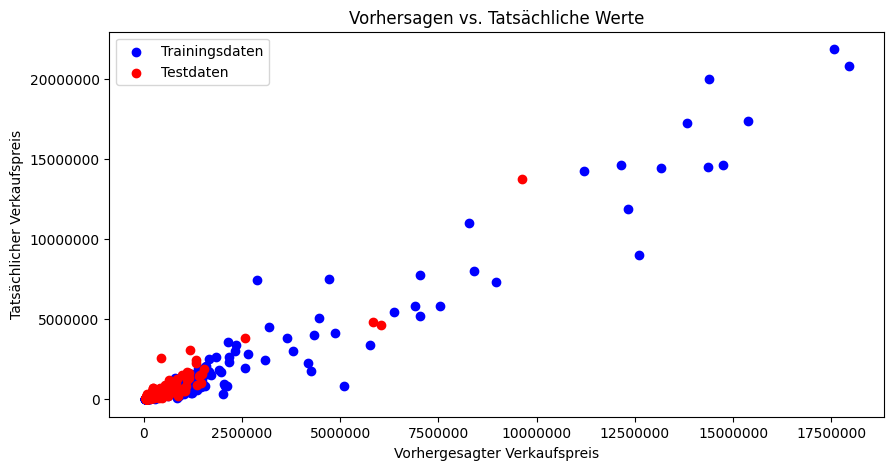

In [12]:
pipe_rf = Pipeline(steps=[
        ('preprocessor', prep),
        ('Random Forest', RandomForestRegressor(**params_rf))
    ])

pipe_rf.fit(train_data[X], train_data[y].values.ravel())

plot_train_vs_test_predictions(pipe_rf, train_data, test_data, X, y)

### Grafik - Learning Curve

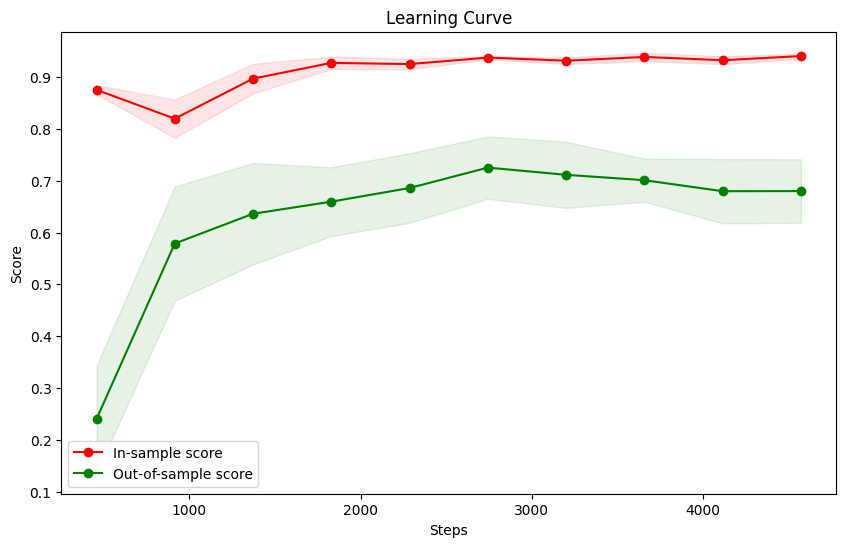

In [13]:
plot_learning_curve(pipe_rf, train_data[X], train_data[y].values.ravel())
plt.show()

### Grafik - Kreuzvalidierung

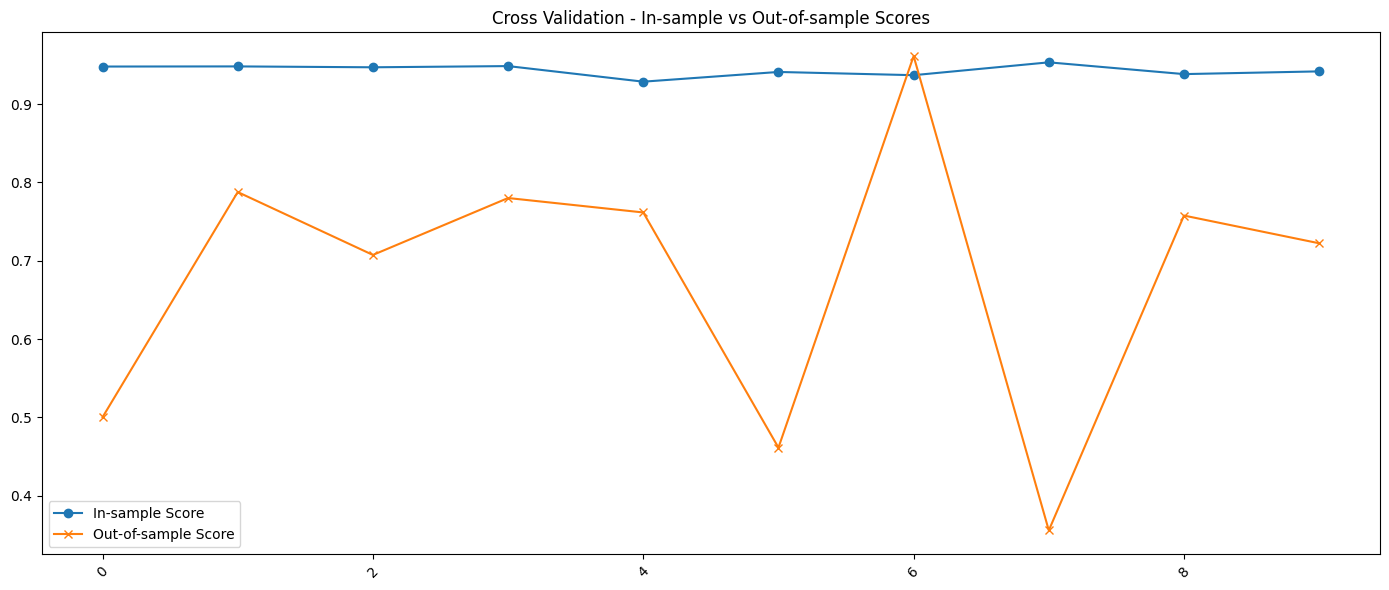

In [14]:
cv_results = cross_validate(estimator=pipe_rf[-1], X=prep.fit_transform(train_data[X]), y=train_data[y].values.ravel(), cv=10, n_jobs=4, return_train_score=True)
plot_train_vs_test_cross_validation(cv_results)

## Gradient Boosting

### Grafik - Vorhergesagte vs Tatsächliche Werte

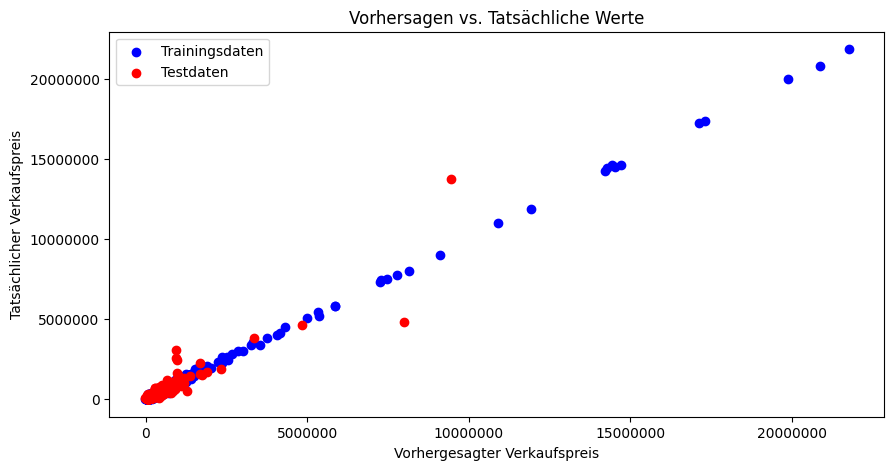

In [15]:
pipe_gb = Pipeline(steps=[
        ('preprocessor', prep),
        ('Gradient Boosting', GradientBoostingRegressor(**params_gb))
    ])

pipe_gb.fit(train_data[X], train_data[y].values.ravel())

plot_train_vs_test_predictions(pipe_gb, train_data, test_data, X, y)

### Grafik - Learning Curve

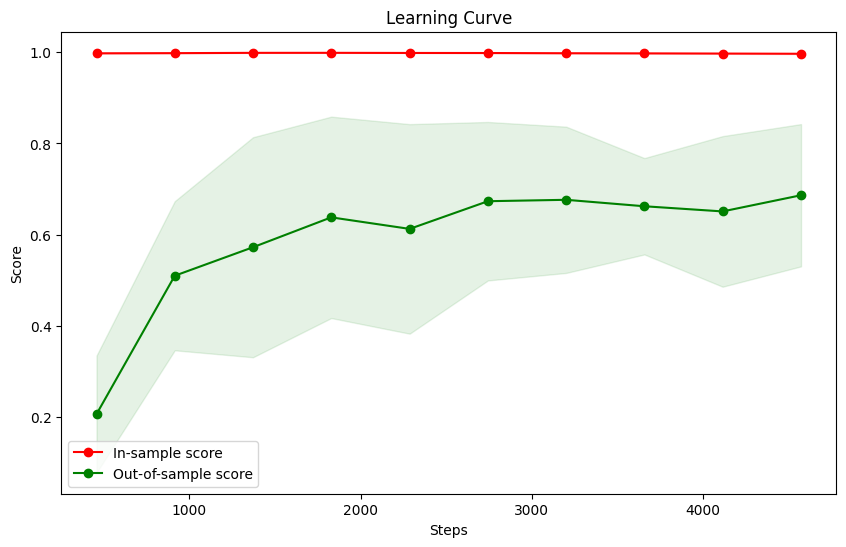

In [16]:
plot_learning_curve(pipe_gb, train_data[X], train_data[y].values.ravel())
plt.show()

### Grafik - Kreuzvalidierung

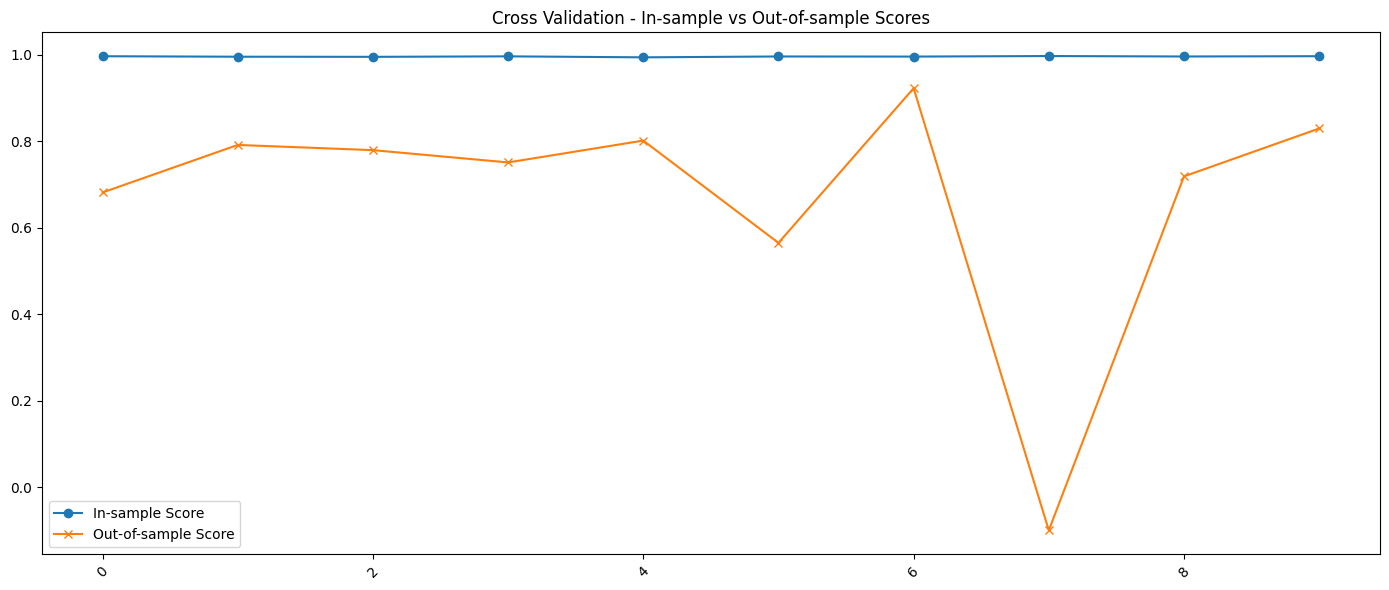

In [17]:
cv_results = cross_validate(estimator=pipe_gb[-1], X=prep.fit_transform(train_data[X]), y=train_data[y].values.ravel(), cv=10, n_jobs=4, return_train_score=True)
plot_train_vs_test_cross_validation(cv_results)

## Entfernen von weiteren Features + Tests anhand vom Random Forest

### Erweitertes Cleansing basierend auf der Verteilung der Features

In [18]:
df = df[df['Stories'] <= 8]
df = df[df['FinishedSqft'] <= 15000]
df = df[df['Units'] <= 15]
df = df[df['Lotsize'] <= 80000]
df = df[df['Bath'] <= 5]
df = df[df['Total_Rooms'] <= 40]
df = df[df['Age'] <= 250]

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
len(df)

6647

### Grafik - Vorhergesagte vs Tatsächliche Werte

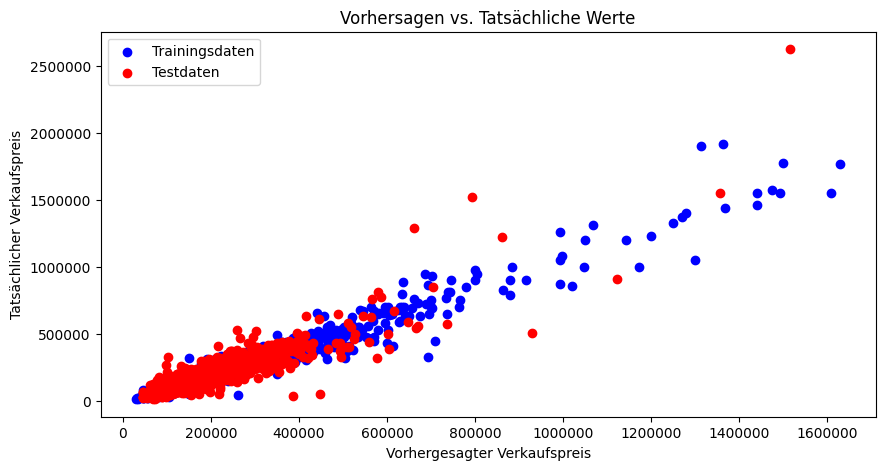

In [24]:
pipe_rf = Pipeline(steps=[
        ('preprocessor', prep),
        ('Random Forest', RandomForestRegressor(**params_rf))
    ])

pipe_rf.fit(train_data[X], train_data[y].values.ravel())

plot_train_vs_test_predictions(pipe_rf, train_data, test_data, X, y)

### Grafik - Learning Curve

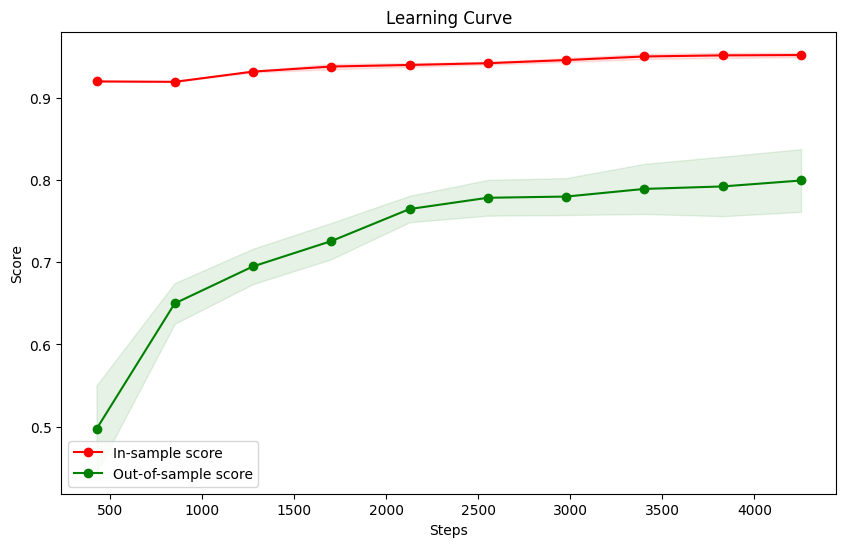

In [25]:
plot_learning_curve(pipe_rf, train_data[X], train_data[y].values.ravel())
plt.show()

### Grafik - Kreuzvalidierung

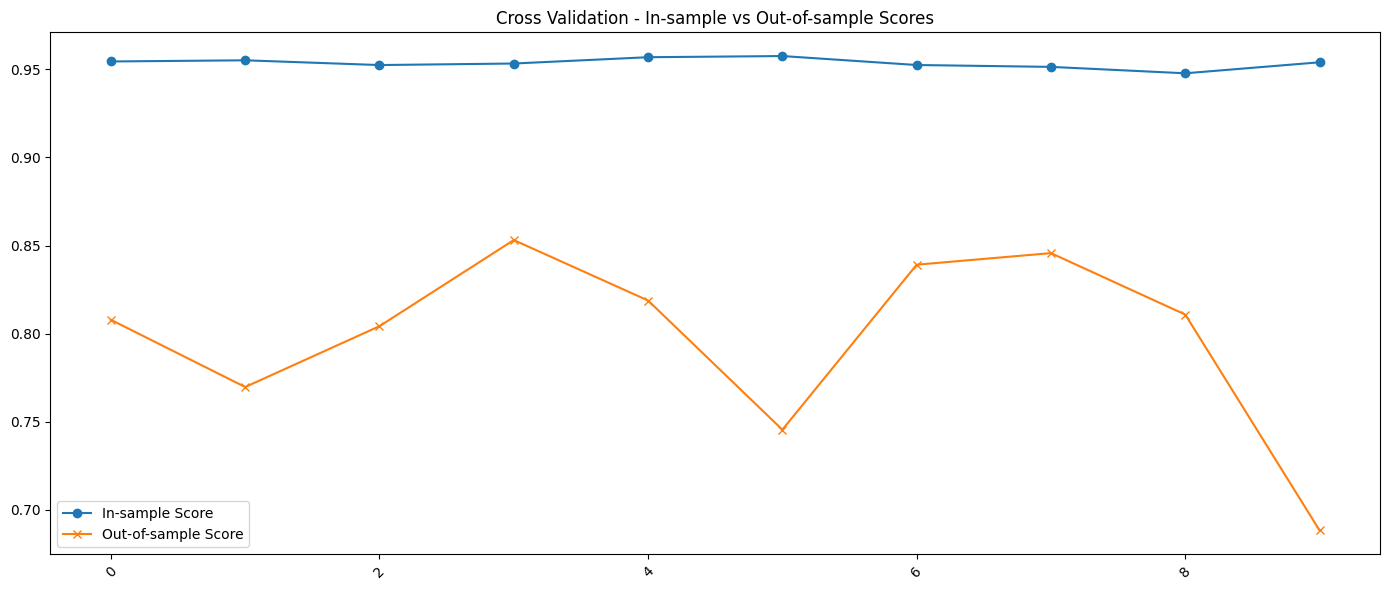

In [21]:
cv_results = cross_validate(estimator=pipe_rf[-1], X=prep.fit_transform(train_data[X]), y=train_data[y].values.ravel(), cv=10, n_jobs=4, return_train_score=True)
plot_train_vs_test_cross_validation(cv_results)